## 1. Data preprocessing (lab 1)

In [20]:
from dataclasses import dataclass
from functools import lru_cache

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from ucimlrepo import fetch_ucirepo


@dataclass
class TrainingData:
    X_train: np.ndarray
    X_test: np.ndarray
    y_train: np.ndarray
    y_test: np.ndarray


@lru_cache
def get_data() -> TrainingData:
    """Returns preprocessed (X_train, X_test, y_train, y_test)."""
    heart_disease = fetch_ucirepo(id=45)
    original_df = heart_disease.data.features

    cat_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
    num_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]

    # Prepare categorical data
    imputer = SimpleImputer(strategy="most_frequent")
    original_df.loc[:, cat_features] = imputer.fit_transform(original_df[cat_features])
    encoder = OneHotEncoder(categories="auto", sparse_output=False)
    encoded_cat_data = encoder.fit_transform(original_df[cat_features])
    encoded_features = encoder.get_feature_names_out(cat_features)
    original_df[encoded_features] = pd.DataFrame(encoded_cat_data, columns=encoded_features)

    # Prepare numerical data
    scaler = MinMaxScaler()
    scaled_num_data = scaler.fit_transform(original_df[num_features])
    original_df[num_features] = pd.DataFrame(scaled_num_data, columns=num_features)

    # Convert DataFrame to feature matrix
    original_df = original_df.drop(columns=cat_features)
    X = original_df.to_numpy()

    # Prepare binary target data
    y = heart_disease.data.targets.to_numpy()
    y_binary = np.where(y >= 1, 1, 0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, test_size=0.2, random_state=42
    )

    return TrainingData(X_train, X_test, y_train, y_test)

### Data type adapter (np.float -> torch.float)

In [21]:
import torch
from torch.utils.data import Dataset


class HeartDiseaseDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

## 2. Model (PyTorch)

In [22]:
from dataclasses import dataclass

import torch.nn as nn

# import torch.nn.functional as nnfunc


@dataclass
class HiddenLayerConfig:
    neurons: int
    f_activ: nn.Module

class HeartDiseaseClassifier(nn.Module):
    """Heart disease classifier that inherits from torch.nn.Module.

    Architecture:
    - Input layer: features_dim neurons.
    - N hidden layers, each with `hidden_layers_config[i].neurons` neurons and
        `hidden_layers_config[i].f_activ` activation function.
    - Output layer: 1 neuron with sigmoid activation function.
    """
    def __init__(
        self,
        input_features: int,
        hidden_layers_config: list[HiddenLayerConfig]
    ):
        super().__init__()
        self.layers = nn.Sequential()
        for i in range(len(hidden_layers_config)):
            input_size = input_features if i == 0 else hidden_layers_config[i-1].neurons
            self.layers.add_module(
                f"linear_{i}",nn.Linear(input_size, hidden_layers_config[i].neurons)
            )
            self.layers.add_module(f"activation_{i}", hidden_layers_config[i].f_activ)
            # self.layers.add_module(nn.Linear(input_size, hidden_layers_config[i].neurons))
            # self.layers.add_module(hidden_layers_config[i].f_activ)

        # Output layer
        self.layers.add_module("output", nn.Linear(hidden_layers_config[-1].neurons, 1))
        self.layers.add_module("output_activation", nn.Sigmoid())

        # Init weights
        self.layers.apply(self._init_weights)

    def _init_weights(self, module: nn.Module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.layers(x)


### Training

In [36]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from torch.nn.modules import Module
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader

# from torch.utils.tensorboard import SummaryWriter
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_one_epoch(
    epoch_index: int,
    model: HeartDiseaseClassifier,
    train_loader: DataLoader,
    loss_fn: Module,
    optimizer: Optimizer,
    tb_writer = None
):
    running_loss = 0.
    last_loss = 0.

    for i, (inputs, labels) in enumerate(train_loader):
        # Zero gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Reshape outputs and labels if needed
        # outputs = outputs.squeeze()
        # labels = labels.float()

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # # Gather statistics
        # running_loss += loss.item()
        # if i % 100 == 99:  # Log every 100 batches
        #     last_loss = running_loss / 100  # loss per batch
        #     tb_x = epoch_index * len(train_loader) + i + 1
        #     tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        #     running_loss = 0.

    return loss


def train_model(
    model: HeartDiseaseClassifier,
    max_epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    loss_fn: Module,
    optimizer: Optimizer,
    # tb_writer: SummaryWriter = None
):
    results = []
    # Initialize training
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")
        model.train()  # Set model to training mode

        # Train for one epoch
        loss = train_one_epoch(
            epoch_index=epoch,
            model=model,
            train_loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
        )

        model.eval()
        correct_preds = 0
        total_preds = 0
        running_val_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss = loss_fn(outputs, labels)
                running_val_loss += val_loss.item()

                # Binary predictions based on threshold 0.5
                binary_preds = (outputs >= 0.5).float()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(binary_preds.cpu().numpy())

                # Accuracy calculation
                correct_preds += (binary_preds == labels).sum().item()
                total_preds += labels.size(0)

        # Calculate metrics for the epoch
        val_accuracy = correct_preds / total_preds
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        avg_val_loss = running_val_loss / len(val_loader)

        results.append({
            "epoch": epoch + 1,
            "recall": recall,
            "f1": f1,
            "accuracy": val_accuracy,
            "cost": avg_val_loss
        })

        print(f"Epoch {epoch+1}/{max_epochs} - Val Loss: {avg_val_loss:.4f} - Accuracy: {val_accuracy:.4f} - Recall: {recall:.4f} - F1 Score: {f1:.4f}")

    print("Training complete!")
    return results

    #     # Print train loss
    #     print(f"Training loss for epoch {epoch+1}: {loss}")

    #     # Validate model after each epoch
    #     model.eval()
    #     correct_preds = 0
    #     total_preds = 0

    #     with torch.no_grad():  # Disable gradient computation for validation
    #         for inputs, labels in val_loader:
    #             # Forward pass
    #             outputs = model(inputs)

    #             # Calculate loss
    #             val_loss = loss_fn(outputs, labels)
    #             # running_val_loss += val_loss.item()

    #             binary_preds = (outputs >= 0.5).float()

    #             labels_np = labels.cpu().numpy()
    #             preds_np = binary_preds.cpu().numpy()

    #             results.append({
    #                 "recall": recall_score(y_true=labels_np, y_pred=preds_np),
    #                 "f1": f1_score(y_true=labels_np, y_pred=preds_np),
    #                 "accuracy": accuracy_score(y_true=labels_np, y_pred=preds_np),
    #                 "cost": val_loss.item()
    #             })

    #             # Calculate accuracy (assuming binary classification)
    #             preds = outputs.argmax(dim=1)  # Get predicted classes
    #             correct_preds += (preds == labels).sum().item()
    #             total_preds += labels.size(0)

    #     # Compute average validation loss and accuracy
    #     # avg_val_loss = running_val_loss / len(val_loader)
    #     val_accuracy = correct_preds / total_preds

    #     # Print validation loss and accuracy
    #     # print(f"Validation loss for epoch {epoch+1}: {avg_val_loss}")
    #     print(f"Validation accuracy for epoch {epoch+1}: {val_accuracy * 100:.2f}%")

    #     # # Log to TensorBoard if provided
    #     # if tb_writer:
    #     #     tb_writer.add_scalar("Loss/train", avg_train_loss, epoch + 1)
    #     #     tb_writer.add_scalar("Loss/val", avg_val_loss, epoch + 1)
    #     #     tb_writer.add_scalar("Accuracy/val", val_accuracy, epoch + 1)

    # print("Training complete!")
    # return results

### Experiments

In [37]:
import torch
import torch.nn as nn

BATCH_SIZE = 30

data = get_data()

train_dataset = HeartDiseaseDataset(data.X_train, data.y_train)
val_dataset = HeartDiseaseDataset(data.X_test, data.y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

model = HeartDiseaseClassifier(
    input_features=data.X_train.shape[1],
    hidden_layers_config=[
        HiddenLayerConfig(14, nn.Sigmoid()),
        HiddenLayerConfig(7, nn.Sigmoid())
    ]
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0075, momentum=0.9)

results = train_model(
    model=model,
    max_epochs=350,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=nn.BCELoss(),
    optimizer=optimizer,
    # tb_writer: SummaryWriter = None
)

Epoch 1/350
Epoch 1/350 - Val Loss: 0.7280 - Accuracy: 0.4754 - Recall: 0.0000 - F1 Score: 0.0000
Epoch 2/350
Epoch 2/350 - Val Loss: 0.7179 - Accuracy: 0.4754 - Recall: 0.0000 - F1 Score: 0.0000
Epoch 3/350
Epoch 3/350 - Val Loss: 0.7229 - Accuracy: 0.4754 - Recall: 0.0000 - F1 Score: 0.0000
Epoch 4/350
Epoch 4/350 - Val Loss: 0.7434 - Accuracy: 0.4754 - Recall: 0.0000 - F1 Score: 0.0000
Epoch 5/350
Epoch 5/350 - Val Loss: 0.7609 - Accuracy: 0.4754 - Recall: 0.0000 - F1 Score: 0.0000
Epoch 6/350
Epoch 6/350 - Val Loss: 0.7379 - Accuracy: 0.4754 - Recall: 0.0000 - F1 Score: 0.0000
Epoch 7/350
Epoch 7/350 - Val Loss: 0.7183 - Accuracy: 0.4754 - Recall: 0.0000 - F1 Score: 0.0000
Epoch 8/350
Epoch 8/350 - Val Loss: 0.7166 - Accuracy: 0.4754 - Recall: 0.0000 - F1 Score: 0.0000
Epoch 9/350
Epoch 9/350 - Val Loss: 0.7176 - Accuracy: 0.4754 - Recall: 0.0000 - F1 Score: 0.0000
Epoch 10/350
Epoch 10/350 - Val Loss: 0.7309 - Accuracy: 0.4754 - Recall: 0.0000 - F1 Score: 0.0000
Epoch 11/350
Epoch

### Visualizations

In [29]:
import matplotlib.pyplot as plt
import numpy as np


def plot_metrics(results: list[dict[str, np.float64]], epochs: int):
    x = [i for i in range(epochs)]
    recall = [results[i]['recall'] for i in x]
    f1 = [results[i]['f1'] for i in x]
    accuracy = [results[i]['accuracy'] for i in x]

    plt.figure(figsize=(8, 6))
    plt.plot(x, recall, linestyle='-', color='r', label='Recall')
    plt.plot(x, f1, linestyle='-', color='g', label='F1 Score')
    plt.plot(x, accuracy, linestyle='-', color='b', label='Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Metric score')
    plt.title('Plot of metric scores')

    plt.xlim(0, epochs)

    plt.legend()

    plt.grid(True)
    plt.show()


def plot_cost(results: list[dict[str, np.float64]], epochs: int):
    x = [i for i in range(epochs)]
    cost = [results[i]['cost'] for i in x]

    plt.figure(figsize=(8, 6))
    plt.plot(x, cost, linestyle='-', color='r', label='Cost')

    plt.xlabel('Epoch')
    plt.ylabel('Cost function value')
    plt.title('Plot of cost value over time (epochs)')

    plt.xlim(0, epochs)

    plt.legend()

    plt.grid(True)
    plt.show()

[{'epoch': 1, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.47540983606557374, 'cost': 0.7280450463294983}, {'epoch': 2, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.47540983606557374, 'cost': 0.7178731759389242}, {'epoch': 3, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.47540983606557374, 'cost': 0.7228679259618124}, {'epoch': 4, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.47540983606557374, 'cost': 0.7433844010035197}, {'epoch': 5, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.47540983606557374, 'cost': 0.7609479029973348}, {'epoch': 6, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.47540983606557374, 'cost': 0.7378719846407572}, {'epoch': 7, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.47540983606557374, 'cost': 0.7183016339937845}, {'epoch': 8, 'recall': np.float64(0.0), 'f1': np.float64(0.0), 'accuracy': 0.47540983606557374, 'cost': 0.7165803909301758},

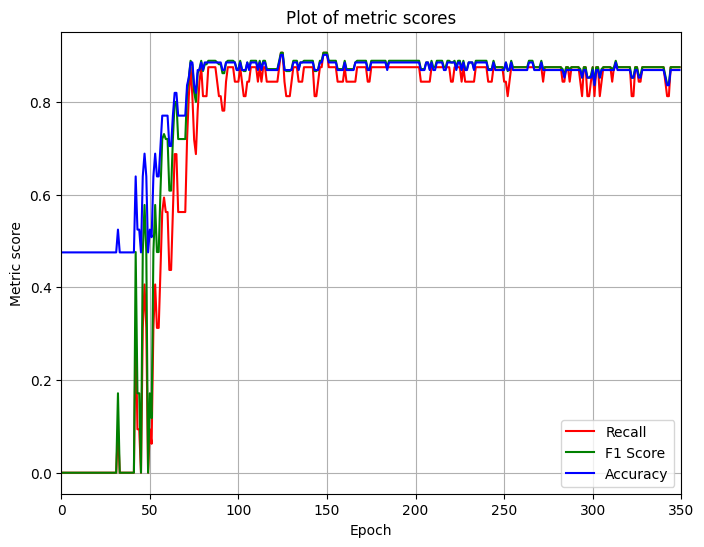

In [38]:
print(results[:10])
plot_metrics(results, 350)

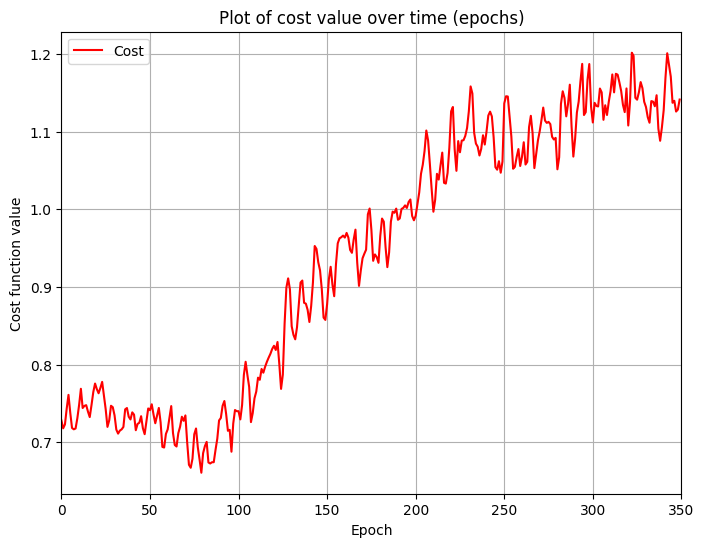

In [40]:
plot_cost(results, 350)